<a href="https://colab.research.google.com/github/Knightler/computer-vision/blob/main/CIPHAR10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 Image Classifer**

In [14]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn as nn

from pathlib import Path
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---
## **Without Augmentation**
---

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

In [17]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                              num_workers=2,
                              pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bb9a27d4890>,
 <torch.utils.data.dataloader.DataLoader at 0x7bbaacbed910>)

In [18]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([6, 4, 5, 8, 7, 0, 2, 1, 4, 0, 9, 4, 8, 4, 4, 0, 6, 9, 9, 7, 2, 0, 1, 9,
         6, 2, 7, 6, 3, 5, 9, 1]))

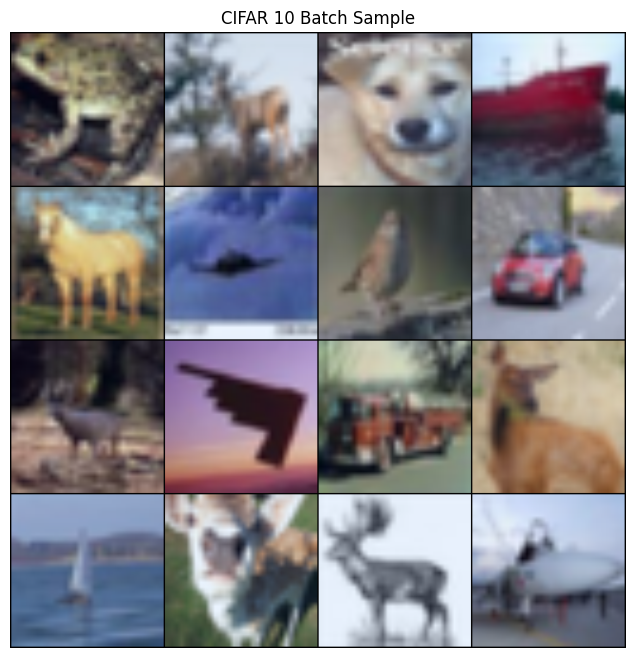

In [19]:
torch.manual_seed(42)

img_grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
plt.axis(False)
plt.title('CIFAR 10 Batch Sample')
plt.show()

In [20]:
class Model0_CNNWithoutAug(nn.Module):
    def __init__(self):
        super(Model0_CNNWithoutAug, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=128,
                               out_channels=64,
                               kernel_size=2,
                               padding=2)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,
                                 stride=3,
                                 padding=1)
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(in_features=64*10*10,
                             out_features=128)
        self.fc2 = nn.Linear(in_features=128,
                             out_features=64)
        self.fc3 = nn.Linear(in_features=64,
                             out_features=10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        # print(x.shape)

        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
model = Model0_CNNWithoutAug()
x = torch.randn(1, 3, 32, 32)
with torch.no_grad():
    x = model.pool(model.relu(model.conv1(x)))
    x = model.pool(model.relu(model.conv2(x)))
    x = model.pool(model.relu(model.conv3(x)))
    print(x.shape)

torch.Size([1, 64, 3, 3])


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
model_0 = Model0_CNNWithoutAug().to(device)
model_0

Model0_CNNWithoutAug(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=3, padding=1, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [24]:
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
from tqdm.auto import tqdm

In [26]:
EPOCHS = 5

total_train_loss = []
total_train_acc = []
total_test_loss = []
total_test_acc = []

for epoch in range(EPOCHS):
    correct = 0
    total = 0
    epoch_loss = 0
    loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')

    model_0.train()
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        y_pred = model_0(images)
        loss = criterion(y_pred, labels)
        preds = y_pred.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    train_acc = correct * 100 / total
    avg_train_loss = epoch_loss / len(train_dataloader)

    total_train_acc.append(train_acc)
    total_train_loss.append(avg_train_loss)

    correct = 0
    total = 0
    epoch_test_loss = 0

    model_0.eval()
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        with torch.inference_mode():
            y_pred_test = model_0(images)
            loss_test = criterion(y_pred_test, labels)
            preds = y_pred_test.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            epoch_test_loss += loss_test.item()


    test_acc = correct * 100 / total
    avg_test_loss = epoch_test_loss / len(test_dataloader)

    total_test_acc.append(test_acc)
    total_test_loss.append(avg_test_loss)

    print(f'===========================================')
    print(f'Epoch {epoch+1} => Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}% | Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1 => Train Loss: 1.4160, Train Accuracy: 49.14% | Test Loss: 1.1881, Test Accuracy: 57.03%


Epoch 2/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2 => Train Loss: 1.0993, Train Accuracy: 60.95% | Test Loss: 1.0640, Test Accuracy: 61.79%


Epoch 3/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3 => Train Loss: 0.9310, Train Accuracy: 67.05% | Test Loss: 1.0286, Test Accuracy: 63.47%


Epoch 4/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4 => Train Loss: 0.7915, Train Accuracy: 72.06% | Test Loss: 1.0615, Test Accuracy: 64.05%


Epoch 5/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5 => Train Loss: 0.6735, Train Accuracy: 76.08% | Test Loss: 1.0394, Test Accuracy: 65.29%


---
## **With Augmentation**
---

In [27]:
transform_with_aug = transforms.Compose([
    transforms.RandomCrop(32,
                          padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

In [28]:
train_dataset_aug = datasets.CIFAR10(root='./data',
                                     train=True, transform=transform_with_aug)
test_dataset_aug = datasets.CIFAR10(root='./data',
                                    train=False, transform=transform_with_aug)

In [29]:
train_dataloader_aug = DataLoader(train_dataset_aug,
                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader_aug = DataLoader(test_dataset_aug,
                                 batch_size=BATCH_SIZE,
                                 shuffle=False,
                                 num_workers=2,
                                 pin_memory=True)

train_dataloader_aug, test_dataloader_aug

(<torch.utils.data.dataloader.DataLoader at 0x7bb9a0eaf9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bb9a27cb6d0>)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=2, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=3, padding=1)
        self.flat = nn.Flatten()

        # Dummy input to calculate flatten size
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 32, 32)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            flatten_dim = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [31]:
model_1 = CNN().to(device)
model_1 = torch.compile(model_1)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
EPOCHS = 50

total_train_loss = []
total_train_acc = []
total_test_loss = []
total_test_acc = []

for epoch in range(EPOCHS):
    correct = 0
    total = 0
    epoch_loss = 0
    loop = tqdm(train_dataloader_aug, desc=f'Epoch {epoch+1}/{EPOCHS}')

    model_1.train()
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        y_pred = model_1(images)
        loss = criterion(y_pred, labels)
        preds = y_pred.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    train_acc = correct * 100 / total
    avg_train_loss = epoch_loss / len(train_dataloader_aug)

    total_train_acc.append(train_acc)
    total_train_loss.append(avg_train_loss)

    correct = 0
    total = 0
    epoch_test_loss = 0

    model_1.eval()
    for images, labels in test_dataloader_aug:
        images, labels = images.to(device), labels.to(device)
        with torch.inference_mode():
            y_pred_test = model_1(images)
            loss_test = criterion(y_pred_test, labels)
            preds = y_pred_test.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            epoch_test_loss += loss_test.item()


    test_acc = correct * 100 / total
    avg_test_loss = epoch_test_loss / len(test_dataloader_aug)

    total_test_acc.append(test_acc)
    total_test_loss.append(avg_test_loss)

    print(f'===========================================')
    print(f'Epoch {epoch+1} => Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}% | Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/50:   0%|          | 0/1563 [00:00<?, ?it/s]

W0322 13:48:00.067000 33924 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1 => Train Loss: 1.6856, Train Accuracy: 37.79% | Test Loss: 1.4769, Test Accuracy: 46.38%


Epoch 2/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2 => Train Loss: 1.3893, Train Accuracy: 49.41% | Test Loss: 1.3046, Test Accuracy: 52.68%


Epoch 3/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3 => Train Loss: 1.2744, Train Accuracy: 53.92% | Test Loss: 1.2094, Test Accuracy: 56.55%


Epoch 4/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4 => Train Loss: 1.1958, Train Accuracy: 57.44% | Test Loss: 1.1818, Test Accuracy: 58.13%


Epoch 5/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5 => Train Loss: 1.1409, Train Accuracy: 59.27% | Test Loss: 1.1345, Test Accuracy: 59.75%


Epoch 6/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6 => Train Loss: 1.1041, Train Accuracy: 60.88% | Test Loss: 1.0901, Test Accuracy: 61.08%


Epoch 7/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7 => Train Loss: 1.0695, Train Accuracy: 62.13% | Test Loss: 1.0969, Test Accuracy: 61.85%


Epoch 8/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8 => Train Loss: 1.0408, Train Accuracy: 63.16% | Test Loss: 1.0618, Test Accuracy: 63.09%


Epoch 9/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9 => Train Loss: 1.0159, Train Accuracy: 64.09% | Test Loss: 1.0282, Test Accuracy: 63.46%


Epoch 10/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10 => Train Loss: 0.9957, Train Accuracy: 64.90% | Test Loss: 0.9725, Test Accuracy: 66.14%


Epoch 11/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bba97fa1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bba97fa1a80> 
  Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
        ^ ^ ^^ ^^^^^^^^^^^^^^^^^^^^^

Epoch 11 => Train Loss: 0.9812, Train Accuracy: 65.49% | Test Loss: 1.0369, Test Accuracy: 63.67%


Epoch 12/50:   0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bba97fa1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bba97fa1a80> 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        ^^^^^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^^    ^if w.is_alive():^^
^ ^ ^  ^ ^  ^^^^^^^

In [ ]:
torch.save(model_1.state_dict(), 'cifar10_model.pth')